In [1]:
import os
import keras
keras.__version__
import tensorflow as tf

from keras import optimizers
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib

Using TensorFlow backend.


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1,2,3"
multi_gpu = len("0,1,2,3".split(','))

In [3]:
def get_session():
    config = tf.ConfigProto(device_count = {'CPU' :24, 'GPU':4})
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

In [4]:
keras.backend.tensorflow_backend.set_session(get_session())

# Modelo Pre-Entrenado CNN

In [5]:
# El directorio de trabajo
processDir = './process'

# Directorio para entrenamiento, validacion y test
train_dir = os.path.join(processDir, 'train')
validation_dir = os.path.join(processDir, 'validation')
test_dir = os.path.join(processDir, 'test')


# Generador de datos

In [6]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

valid_generator = valid_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='categorical')

Found 14530 images belonging to 120 classes.
Found 3025 images belonging to 120 classes.


In [7]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 120)


# Modelo InceptionV3

In [8]:
from keras.applications import InceptionV3

if multi_gpu > 1:  
    with tf.device('/cpu:0'):
        conv_base = InceptionV3(weights='imagenet',
                                include_top=False,
                                input_shape=(150, 150, 3))

Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 1s 0us/step


In [9]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 74, 74, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 32)   0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

In [10]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 26,552,472
Trainable params: 26,518,040
Non-trainable params: 34,432
_________________________________________________________________


In [12]:
conv_base.trainable = False

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dense_2 (Dense)              (None, 120)               30840     
Total params: 26,552,472
Trainable params: 4,749,688
Non-trainable params: 21,802,784
_________________________________________________________________


In [14]:
if multi_gpu > 1:
    parallel_model = multi_gpu_model(model, gpus=multi_gpu)

# Optimizador

In [15]:
from keras import optimizers

parallel_model.compile(loss='categorical_crossentropy',
                       optimizer=optimizers.RMSprop(lr=1e-4),
                       metrics=['acc'])

# Entrenamiento

In [16]:
history = parallel_model.fit_generator(train_generator,
                                       steps_per_epoch=100,
                                       epochs=500,
                                       validation_data=valid_generator,
                                       validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
100/100 [==============================] - 44s 445ms/step - loss: 4.8994 - acc: 0.0175 - val_loss: 5.3246 - val_acc: 0.0210
Epoch 2/500
100/100 [==============================] - 16s 155ms/step - loss: 4.8169 - acc: 0.0115 - val_loss: 5.2193 - val_acc: 0.0320
Epoch 3/500
100/100 [==============================] - 16s 155ms/step - loss: 4.8029 - acc: 0.0175 - val_loss: 4.9025 - val_acc: 0.0290
Epoch 4/500
100/100 [==============================] - 16s 159ms/step - loss: 4.7549 - acc: 0.0215 - val_loss: 4.8532 - val_acc: 0.0244
Epoch 5/500
100/100 [==============================] - 16s 158ms/step - loss: 4.7408 - acc: 0.0170 - val_loss: 5.0609 - val_acc: 0.0570
Epoch 6/500
100/100 [==============================] - 16s 156ms/step - loss: 4.7187 - acc: 0.0225 - val_loss: 4.6394 - val_acc: 0.0780
Epoch 7/500
100/100 [==============================] - 16s 155ms/step - loss: 4.6810 - acc: 0.0290 - val_loss: 5.4799 - val_acc: 0.0822


Epoch 59/500
100/100 [==============================] - 16s 156ms/step - loss: 3.5978 - acc: 0.1820 - val_loss: 4.6284 - val_acc: 0.4050
Epoch 60/500
100/100 [==============================] - 15s 153ms/step - loss: 3.6205 - acc: 0.1645 - val_loss: 4.2065 - val_acc: 0.4430
Epoch 61/500
100/100 [==============================] - 15s 154ms/step - loss: 3.5949 - acc: 0.1645 - val_loss: 4.2211 - val_acc: 0.4365
Epoch 62/500
100/100 [==============================] - 16s 156ms/step - loss: 3.6387 - acc: 0.1645 - val_loss: 4.0744 - val_acc: 0.4570
Epoch 63/500
100/100 [==============================] - 15s 154ms/step - loss: 3.6096 - acc: 0.1695 - val_loss: 4.2102 - val_acc: 0.4450
Epoch 64/500
100/100 [==============================] - 15s 154ms/step - loss: 3.6362 - acc: 0.1625 - val_loss: 4.4121 - val_acc: 0.4396
Epoch 65/500
100/100 [==============================] - 15s 155ms/step - loss: 3.6155 - acc: 0.1715 - val_loss: 4.8697 - val_acc: 0.4110
Epoch 66/500
100/100 [===================

100/100 [==============================] - 15s 155ms/step - loss: 3.3994 - acc: 0.1985 - val_loss: 4.4684 - val_acc: 0.4830
Epoch 119/500
100/100 [==============================] - 16s 155ms/step - loss: 3.4667 - acc: 0.1970 - val_loss: 4.2889 - val_acc: 0.4843
Epoch 120/500
100/100 [==============================] - 16s 155ms/step - loss: 3.4017 - acc: 0.1960 - val_loss: 4.8120 - val_acc: 0.4440
Epoch 121/500
100/100 [==============================] - 15s 153ms/step - loss: 3.4930 - acc: 0.1885 - val_loss: 4.3369 - val_acc: 0.4780
Epoch 122/500
100/100 [==============================] - 15s 154ms/step - loss: 3.4791 - acc: 0.1905 - val_loss: 4.2915 - val_acc: 0.4843
Epoch 123/500
100/100 [==============================] - 16s 155ms/step - loss: 3.5067 - acc: 0.1770 - val_loss: 4.4543 - val_acc: 0.4820
Epoch 124/500
100/100 [==============================] - 16s 156ms/step - loss: 3.3969 - acc: 0.2065 - val_loss: 4.1673 - val_acc: 0.4840
Epoch 125/500
100/100 [=========================

100/100 [==============================] - 16s 155ms/step - loss: 3.3804 - acc: 0.1965 - val_loss: 4.2097 - val_acc: 0.5046
Epoch 178/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3879 - acc: 0.2060 - val_loss: 4.5663 - val_acc: 0.4750
Epoch 179/500
100/100 [==============================] - 15s 154ms/step - loss: 3.4138 - acc: 0.2000 - val_loss: 4.9286 - val_acc: 0.4600
Epoch 180/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3811 - acc: 0.1990 - val_loss: 5.0111 - val_acc: 0.4741
Epoch 181/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3201 - acc: 0.2265 - val_loss: 4.1447 - val_acc: 0.5030
Epoch 182/500
100/100 [==============================] - 16s 155ms/step - loss: 3.2800 - acc: 0.2240 - val_loss: 4.6712 - val_acc: 0.4840
Epoch 183/500
100/100 [==============================] - 15s 154ms/step - loss: 3.4025 - acc: 0.2105 - val_loss: 4.7525 - val_acc: 0.4619
Epoch 184/500
100/100 [=========================

100/100 [==============================] - 16s 157ms/step - loss: 3.3548 - acc: 0.2105 - val_loss: 4.2902 - val_acc: 0.4910
Epoch 237/500
100/100 [==============================] - 16s 157ms/step - loss: 3.2954 - acc: 0.2290 - val_loss: 4.5762 - val_acc: 0.4960
Epoch 238/500
100/100 [==============================] - 16s 156ms/step - loss: 3.2820 - acc: 0.2210 - val_loss: 4.6416 - val_acc: 0.4924
Epoch 239/500
100/100 [==============================] - 16s 156ms/step - loss: 3.3778 - acc: 0.2060 - val_loss: 4.9075 - val_acc: 0.4770
Epoch 240/500
100/100 [==============================] - 16s 156ms/step - loss: 3.3069 - acc: 0.2350 - val_loss: 4.6461 - val_acc: 0.4940
Epoch 241/500
100/100 [==============================] - 15s 154ms/step - loss: 3.3280 - acc: 0.2240 - val_loss: 5.0693 - val_acc: 0.4741
Epoch 242/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3897 - acc: 0.2230 - val_loss: 4.6236 - val_acc: 0.4900
Epoch 243/500
100/100 [=========================

100/100 [==============================] - 15s 154ms/step - loss: 3.3575 - acc: 0.2225 - val_loss: 4.6178 - val_acc: 0.4924
Epoch 296/500
100/100 [==============================] - 16s 157ms/step - loss: 3.3494 - acc: 0.2115 - val_loss: 5.3343 - val_acc: 0.4610
Epoch 297/500
100/100 [==============================] - 15s 154ms/step - loss: 3.3254 - acc: 0.2305 - val_loss: 4.5623 - val_acc: 0.5120
Epoch 298/500
100/100 [==============================] - 15s 153ms/step - loss: 3.3022 - acc: 0.2170 - val_loss: 5.4058 - val_acc: 0.4629
Epoch 299/500
100/100 [==============================] - 16s 162ms/step - loss: 3.3311 - acc: 0.2220 - val_loss: 5.2237 - val_acc: 0.4770
Epoch 300/500
100/100 [==============================] - 15s 154ms/step - loss: 3.3492 - acc: 0.2240 - val_loss: 4.7805 - val_acc: 0.4770
Epoch 301/500
100/100 [==============================] - 16s 155ms/step - loss: 3.2751 - acc: 0.2230 - val_loss: 4.9619 - val_acc: 0.4843
Epoch 302/500
100/100 [=========================

100/100 [==============================] - 15s 155ms/step - loss: 3.3253 - acc: 0.2200 - val_loss: 5.3617 - val_acc: 0.4810
Epoch 355/500
100/100 [==============================] - 15s 155ms/step - loss: 3.3397 - acc: 0.2215 - val_loss: 5.9640 - val_acc: 0.4390
Epoch 356/500
100/100 [==============================] - 15s 154ms/step - loss: 3.3787 - acc: 0.2070 - val_loss: 5.6253 - val_acc: 0.4457
Epoch 357/500
100/100 [==============================] - 15s 155ms/step - loss: 3.3147 - acc: 0.2230 - val_loss: 5.2761 - val_acc: 0.4720
Epoch 358/500
100/100 [==============================] - 15s 155ms/step - loss: 3.3196 - acc: 0.2300 - val_loss: 5.5882 - val_acc: 0.4500
Epoch 359/500
100/100 [==============================] - 16s 156ms/step - loss: 3.3251 - acc: 0.2230 - val_loss: 5.1181 - val_acc: 0.4843
Epoch 360/500
100/100 [==============================] - 15s 154ms/step - loss: 3.3817 - acc: 0.2070 - val_loss: 4.9890 - val_acc: 0.4920
Epoch 361/500
100/100 [=========================

100/100 [==============================] - 16s 156ms/step - loss: 3.3929 - acc: 0.2020 - val_loss: 5.6005 - val_acc: 0.4740
Epoch 414/500
100/100 [==============================] - 16s 156ms/step - loss: 3.3389 - acc: 0.2350 - val_loss: 4.8900 - val_acc: 0.4873
Epoch 415/500
100/100 [==============================] - 15s 155ms/step - loss: 3.3276 - acc: 0.2190 - val_loss: 5.5193 - val_acc: 0.4810
Epoch 416/500
100/100 [==============================] - 15s 155ms/step - loss: 3.3177 - acc: 0.2390 - val_loss: 5.7610 - val_acc: 0.4500
Epoch 417/500
100/100 [==============================] - 15s 154ms/step - loss: 3.3757 - acc: 0.2110 - val_loss: 5.4567 - val_acc: 0.4619
Epoch 418/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3288 - acc: 0.2320 - val_loss: 5.5898 - val_acc: 0.4600
Epoch 419/500
100/100 [==============================] - 15s 155ms/step - loss: 3.3728 - acc: 0.2195 - val_loss: 5.4973 - val_acc: 0.4710
Epoch 420/500
100/100 [=========================

100/100 [==============================] - 16s 157ms/step - loss: 3.3290 - acc: 0.2205 - val_loss: 5.5274 - val_acc: 0.4741
Epoch 473/500
100/100 [==============================] - 16s 156ms/step - loss: 3.3563 - acc: 0.2240 - val_loss: 5.6969 - val_acc: 0.4750
Epoch 474/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3325 - acc: 0.2230 - val_loss: 5.7121 - val_acc: 0.4740
Epoch 475/500
100/100 [==============================] - 16s 156ms/step - loss: 3.4218 - acc: 0.2075 - val_loss: 5.7301 - val_acc: 0.4599
Epoch 476/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3500 - acc: 0.2170 - val_loss: 6.0106 - val_acc: 0.4680
Epoch 477/500
100/100 [==============================] - 16s 155ms/step - loss: 3.3246 - acc: 0.2325 - val_loss: 6.2182 - val_acc: 0.4370
Epoch 478/500
100/100 [==============================] - 16s 157ms/step - loss: 3.2890 - acc: 0.2215 - val_loss: 5.9575 - val_acc: 0.4569
Epoch 479/500
100/100 [=========================

# Graficos

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

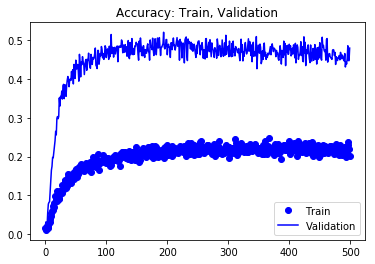

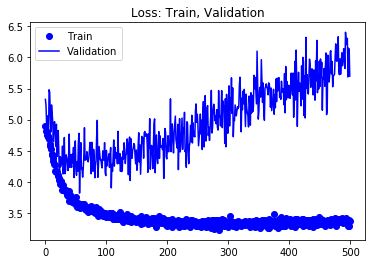

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Train')
plt.plot(epochs, val_acc, 'b', label='Validation')
plt.title('Accuracy: Train, Validation')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train')
plt.plot(epochs, val_loss, 'b', label='Validation')
plt.title('Loss: Train, Validation')
plt.legend()

plt.show()

In [19]:
model.save('model_InceptionV3_RMSProp.h5')